In [186]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline 

import math

from project_lib import Project # from watson studio desktop to read data from projects

In [3]:
# next few lines are for cplex
import sys 
try:   
    import docplex.mp
    import cplex
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install docplex
        !pip install cplex
    else:
        !pip install --user docplex
        !pip install --user cplex

from docplex.mp.advmodel import AdvModel as Model        

# Read Stock Data

In [153]:
project = Project()

In [154]:
stocks = pd.read_csv(project.get_file("history_60d.csv"))
st = stocks[['date','symbol','close','volume']]
list_stocks = ['IBM','APPL','AMZN','NFLX','NVDA','FB','GOOGL','MSFT']
st_r = st[st['symbol'].isin(list_stocks)]
# print prices from a few stocks
stocks_data = st_r.pivot(index='date', columns='symbol', values='close')
stocks_data.head()

symbol,AMZN,FB,GOOGL,IBM,MSFT,NFLX,NVDA
date,,,,,,,
2019-02-20,1622.099976,162.559998,1120.589966,138.000000,107.150002,359.910004,158.550003
2019-02-21,1619.439941,160.039993,1104.209961,137.839996,109.410004,356.970001,155.770004
2019-02-22,1631.560059,161.889999,1116.560059,139.250000,110.970001,363.019989,159.190002
2019-02-25,1633.000000,164.619995,1117.329956,139.460007,111.589996,363.910004,158.690002
2019-02-26,1636.400024,164.130005,1122.010010,139.720001,112.360001,364.970001,157.100006


## Get S&P 500 Tickers from wikipedia:

+ code: https://pythonprogramming.net/sp500-company-price-data-python-programming-for-finance/

In [156]:
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text[0:-1]
        tickers.append(ticker)

    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)

    return tickers

sp500 = save_sp500_tickers()

# Get Data in the Right Shape for Optimization with CPLEX

+ drop duplicates 
+ pivot data to get a matrix of dates (rows) by stocks (columns) 


In [157]:
st = st.drop_duplicates(subset =['date','symbol'],keep = False)
prices = st.pivot(index='date', columns='symbol', values='close')

In [158]:
prices.head()

symbol,A,AA,AAAU,AABA,AAC,AADR,AAL,AAMC,AAME,AAN,...,ZSL,ZTO,ZTR,ZTS,ZUMZ,ZUO,ZVO,ZYME,ZYNE,ZYXI
date,,,,,,,,,,,,,,,,,,,,,
2019-02-20,78.559998,29.240000,13.38,69.400002,3.12,45.840000,35.060001,33.980000,2.63,53.709999,...,34.610001,19.230000,10.56,94.389999,25.790001,23.180000,NaN,15.06,4.90,5.22
2019-02-21,77.889999,29.580000,13.23,69.839996,2.94,45.630001,34.980000,35.000000,2.63,54.180000,...,35.770000,19.450001,10.51,93.470001,25.090000,23.309999,NaN,15.06,5.18,5.40
2019-02-22,78.419998,30.170000,13.28,71.720001,2.98,46.119999,35.490002,38.799999,2.85,54.970001,...,35.279999,19.610001,10.50,94.610001,25.000000,23.969999,NaN,14.94,5.12,5.43
2019-02-25,79.339996,30.780001,13.26,74.029999,3.09,46.439999,35.900002,39.000000,2.79,54.230000,...,35.450001,19.700001,10.55,94.389999,24.680000,24.240000,NaN,14.97,5.04,5.57
2019-02-26,78.550003,30.850000,13.28,74.250000,3.02,46.389999,36.250000,39.320000,2.80,55.000000,...,35.299999,19.490000,10.56,93.489998,24.480000,23.639999,NaN,15.21,5.25,5.40


+ stock prices are from February 20, 2019 to April 18, 2019
+ filter out stocks that are not in the S&P500 index
+ computing the 2-month returns as last_price / initial_price - 1

In [159]:
num_days = prices.shape[0]

print("1st. day in data: ", prices.index[0]) 
print("Last day in data: ", prices.index[num_days-1])

1st. day in data:  2019-02-20
Last day in data:  2019-04-18


In [241]:
results = []
list_stocks = []

for stock in sp500:
    try:
        if prices[stock].isna().count() == num_days: # only getting stocks without nulls
            initial_price = prices[stock][0]
            last_price = prices[stock][num_days-1]
            ret = (last_price / initial_price - 1)
            if math.isnan(ret):
                1
            else:
                results.append((stock,initial_price, last_price, ret))
                list_stocks.append(stock)
    except:
        print(stock, " not in data")

df_stocks = pd.DataFrame(results,columns=['stock','initial_price','last_price','ret'])    
df_stocks.index = df_stocks.stock
df_stocks = df_stocks[['initial_price','last_price','ret']]

print(df_stocks.shape)

AMCR  not in data
BRK.B  not in data
BF.B  not in data
CTVA  not in data
DD  not in data
(499, 3)


+ distribution of returns

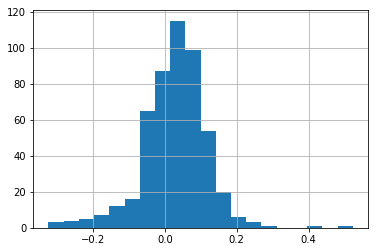

In [242]:
df_stocks.ret.hist(bins=20)

+ compute daily returns
+ compute covariance matrix of daily returns (multiple by number of observations to have an estimate of the 2-month volatility)

In [244]:
daily_returns = prices[df_stocks.index].pct_change(1)
daily_returns = daily_returns.iloc[1:] # deletes the first row that has no daily return
daily_returns = daily_returns.dropna(axis='columns') # filter out stocks with NaNs

In [245]:
daily_returns.columns

Index(['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP',
       'AES',
       ...
       'WLTW', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XYL', 'YUM', 'ZBH', 'ZION',
       'ZTS'],
      dtype='object', name='symbol', length=499)

In [246]:
df_var = daily_returns[daily_returns.columns].cov() * daily_returns.shape[0]

# Decision Optimization with CPLEX (Community Edition)

+ define the quadratic programming model
+ create variables as the fraction to invest on each stock
+ define constraints 
    + sum of fractions need to be 1 (all the money will be invested)
    + target return is >= 9%
+ define objective function: minimize variance    
    

In [254]:
mdl = Model(name='stocks_portfolio')
df_stocks['frac'] = mdl.continuous_var_list(df_stocks.index, name='frac', ub=1)

In [255]:
# sum of fractions equal 100%
mdl.add_constraint(mdl.sum(df_stocks.frac) == 1);

# ensure minimal return on investment
target_return = .09
actual_return = mdl.dot(df_stocks.frac, df_stocks['ret'])
mdl.add_kpi(actual_return, 'ROI')
ct_return = mdl.add_constraint(actual_return >= target_return)

In [256]:
# KPIs
fracs = df_stocks.frac
variance = mdl.sum(float(df_var[s1][s2]) * fracs[s1] * fracs[s2] for s1 in df_stocks.index for s2 in df_stocks.index)
mdl.add_kpi(variance, 'Variance')

# finally the objective
mdl.minimize(variance)

In [258]:
assert mdl.solve(url=None, key=None), "Solve failed"
mdl.report()

* model stocks_portfolio solved with objective = 0.000
*  KPI: ROI      = 0.090
*  KPI: Variance = 0.000


In [260]:
fractions = []
all_fracs = {}
for row in df_stocks.itertuples():
    pct = 100 * row.frac.solution_value
    all_fracs[row[0]] = pct
    if pct>1e-3:
        print('-- fraction allocated in: {0:<12}: {1:.2f}%'.format(row[0], pct))
        fractions.append((row[0],pct))

-- fraction allocated in: AVB         : 3.35%
-- fraction allocated in: BBY         : 1.19%
-- fraction allocated in: BIIB        : 1.38%
-- fraction allocated in: COG         : 0.69%
-- fraction allocated in: CCL         : 0.64%
-- fraction allocated in: CMG         : 3.47%
-- fraction allocated in: CHD         : 8.74%
-- fraction allocated in: CPRT        : 3.42%
-- fraction allocated in: COTY        : 11.14%
-- fraction allocated in: DHI         : 4.57%
-- fraction allocated in: DHR         : 3.07%
-- fraction allocated in: DISCA       : 2.81%
-- fraction allocated in: DLTR        : 5.46%
-- fraction allocated in: EVRG        : 3.80%
-- fraction allocated in: FB          : 2.95%
-- fraction allocated in: SJM         : 4.83%
-- fraction allocated in: KSS         : 0.84%
-- fraction allocated in: LLY         : 4.40%
-- fraction allocated in: LKQ         : 3.39%
-- fraction allocated in: NEE         : 3.40%
-- fraction allocated in: PGR         : 0.22%
-- fraction allocated in: PSA    

In [264]:
fr = pd.DataFrame(fractions,columns=['stock','frac'])
fr.sort_values(by='frac',ascending=False).head()

,stock,frac
8,COTY,11.138412
23,SRE,9.140616
6,CHD,8.741114
12,DLTR,5.460468
27,YUM,5.218066


In [265]:
fr.shape

(28, 2)